## Imports

In [1]:
import torch

import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn.metrics import accuracy_score

## Load data and split for train/test

In [2]:
combined_df = pd.read_csv("../data/processed/combined_dataset.csv")
combined_df.set_index(["data_id"], inplace=True)

In [3]:
from sklearn.model_selection import train_test_split

combined_data = np.array(
    list(set(zip(combined_df.index.get_level_values(0), combined_df.label)))
)
data_ids = combined_data[:, 0]
labels = combined_data[:, 1]
train_data_ids, test_data_ids, _, _ = train_test_split(
    data_ids, labels, test_size=0.2, random_state=31, stratify=labels
)

In [4]:
train_x = []
train_y = []
for current_idx, train_data_id in enumerate(train_data_ids):
    current_point = combined_df.loc[train_data_id]
    train_x.append(
        torch.Tensor(
            current_point[["x", "y", "z"]].to_numpy().transpose(1, 0).flatten()
        )
    )
    train_y.append(
        torch.Tensor([1.0] if current_point["label"].unique()[0] == 1 else [0.0])
    )

train_x = torch.vstack(train_x)
train_y = torch.squeeze(torch.vstack(train_y))

In [5]:
train_x.shape, train_y.shape

(torch.Size([155, 225]), torch.Size([155]))

In [6]:
test_x = []
test_y = []
for current_idx, test_data_id in enumerate(test_data_ids):
    current_point = combined_df.loc[test_data_id]
    test_x.append(
        torch.Tensor(
            current_point[["x", "y", "z"]].to_numpy().transpose(1, 0).flatten()
        )
    )
    test_y.append(
        torch.Tensor([1.0] if current_point["label"].unique()[0] == 1 else [0.0])
    )

test_x = torch.vstack(test_x)
test_y = torch.squeeze(torch.vstack(test_y))

In [7]:
test_x.shape, test_y.shape

(torch.Size([39, 225]), torch.Size([39]))

## Model Definition

In [8]:
class ClassificationNetMLP(torch.nn.Module):
    def __init__(self, input_size=225, hidden_size=50, output_size=2):
        super(ClassificationNetMLP, self).__init__()
        self.pred_net = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        scores = self.pred_net(x)
        return scores

In [9]:
model = ClassificationNetMLP()

## Training

In [10]:
lr = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [11]:
def get_accuracy(scores, labels):
    num_data = scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = predicted_labels == labels
    num_matches = indicator.sum()
    return 100 * num_matches.float() / num_data

In [12]:
iterations = 200

train_losses = []
train_accuracies = []
test_accuracies = []

for curr_iter in tqdm(range(iterations), desc="Training Progress"):
    optimizer.zero_grad()
    model_in = train_x
    model_in.requires_grad_()
    model_out = model(model_in)
    loss = criterion(model_out, train_y.long())
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    train_accuracies.append(get_accuracy(model_out, train_y))

    if curr_iter % 10 == 0:
        with torch.no_grad():
            test_out = model(test_x)
            test_accuracies.append(get_accuracy(test_out, test_y))

Training Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1063.50it/s]


## Training Results

<AxesSubplot:>

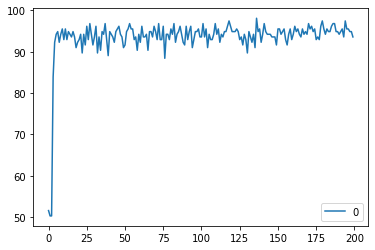

In [13]:
pd.DataFrame(train_accuracies).plot()

<AxesSubplot:>

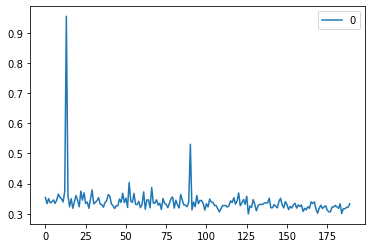

In [14]:
pd.DataFrame(train_losses[10:]).plot()

<AxesSubplot:>

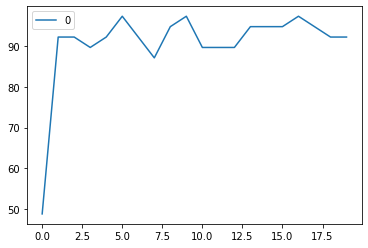

In [15]:
pd.DataFrame(test_accuracies).plot()

In [16]:
get_accuracy(test_out, test_y)

tensor(92.3077)

## Persist Model parameters

In [18]:
# torch.save(model.state_dict(), "../data/checkpoints/mlp.pth")

## Evaluation

In [20]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

def compute_evaluation_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
    }

compute_evaluation_metrics(test_y.numpy(), test_out.argmax(dim=1).numpy())

{'accuracy': 0.9230769230769231, 'f1': 0.9189189189189189, 'recall': 0.85}